### Начало

Начало соответствует предложенному решению (с небольшим рефакторингом)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%config InlineBackend.figure_format = 'retina'

import seaborn as sns

In [2]:
df_orders = pd.read_csv('orders.csv')
df_orders['order_month'] = df_orders['order_date'].apply(lambda x: x[0:7])
df_orders['order_year'] = df_orders['order_date'].apply(lambda x: x[0:4])
df_orders.sample(3, random_state=42)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year
2503,152247,2016-11-07,Standard,MA-17995,1603.136,2016-11,2016
3509,135167,2017-06-15,Standard,SC-20800,4.260,2017-06,2017
4267,133130,2014-09-27,Standard,TH-21100,685.900,2014-09,2014


In [3]:
df_customers = pd.read_csv('customers.csv').rename(columns={'id': 'customer_id'})
df_customers.sample(3, random_state=42)

,customer_id,name,segment,state,city
137,DJ-13510,Don Jones,Corporate,Tennessee,Murfreesboro
198,MD-17350,Maribeth Dona,Consumer,Arkansas,Fayetteville
739,NF-18475,Neil Franzosisch,Home Office,Illinois,Rockford


In [4]:
df_merge = df_orders.merge(df_customers, on='customer_id', how='inner')
df_merge.sample(3, random_state=42)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city
2503,161991,2015-09-26,Second,SC-20725,1116.480,2015-09,2015,Steven Cartwright,Consumer,Delaware,Wilmington
3509,114804,2017-10-17,Second,BF-11020,52.792,2017-10,2017,Barry Franzosisch,Corporate,Wisconsin,Green Bay
4267,136196,2015-11-28,Standard,TP-21415,322.590,2015-11,2015,Tom Prescott,Consumer,Washington,Seattle


In [5]:
df_first = df_merge.groupby('customer_id').order_year.min().reset_index()
df_first.columns = ['customer_id', 'first_order']
df_first.sample(3, random_state=42)

,customer_id,first_order
137,CC-12685,2014
198,DB-13660,2014
739,TB-21595,2014


In [6]:
df_full = df_merge.merge(df_first, on='customer_id', how='inner')
df_full.sample(3, random_state=42)

,id,order_date,ship_mode,customer_id,sales,order_month,order_year,name,segment,state,city,first_order
2503,161991,2015-09-26,Second,SC-20725,1116.480,2015-09,2015,Steven Cartwright,Consumer,Delaware,Wilmington,2014
3509,114804,2017-10-17,Second,BF-11020,52.792,2017-10,2017,Barry Franzosisch,Corporate,Wisconsin,Green Bay,2014
4267,136196,2015-11-28,Standard,TP-21415,322.590,2015-11,2015,Tom Prescott,Consumer,Washington,Seattle,2015


### Полезные функции

Далее идут две функции для подготовки данных и отрисовки когорт

In [7]:
def prep_table_for_cohort_analysis(df, filter_query=None):
    """
    Функция для подготовки датасета с когортами
    """
    df = df.copy()

    df_query = df.query(filter_query) if filter_query else df

    df_users = df_query.groupby(
        ['customer_id', 'first_order', 'order_year']
    ).agg(
        {'sales': 'sum', 'id': 'count'}
    ).reset_index()
    df_users['unique_id'] = 1

    # print(df_users.shape); display(df_users.sample(3, random_state=42))

    df_cohort = df_users.groupby(
        ['first_order', 'order_year']
    ).sum().reset_index()

    # print(df_cohort.shape); display(df_cohort.sample(3, random_state=42))
    
    return df_cohort

In [8]:
def show_table_and_plot_cohorts(df, column_of_interest, extra_name=''):
    """
    Функция для отрисовки когорт
    """
    df = df.copy()

    base = df.groupby('first_order')[column_of_interest].first()
    base.name = 'base'

    df[column_of_interest] /= df.groupby('first_order')[column_of_interest].transform('first')

    df_pivot = df.pivot_table(index='first_order', columns='order_year', values=column_of_interest)

    table = pd.concat([base, df_pivot], axis=1)
    table.index.names = ['cohort']

    # display(table)

    df['order_year'] = 'Y+' + (df.order_year.astype(int) - df.first_order.astype(int)).astype(str)

    retention_matrix = df.pivot_table(index='first_order', columns='order_year', values=column_of_interest)

    base = pd.DataFrame(base)
    base.index.names = ['cohort']

    # based on https://github.com/erykml/medium_articles/blob/master/Business/cohort_analysis.ipynb
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(6, 4), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

        # retention matrix
        sns.heatmap(retention_matrix, 
                    mask=retention_matrix.isnull(), 
                    annot=True, 
                    fmt='.0%', 
                    cmap='RdYlGn', 
                    ax=ax[1])
        ax[1].set_title(f"Yearly Cohorts '{column_of_interest}' Retention, {extra_name}", fontsize=12)
        ax[1].set(xlabel='# of periods', ylabel='')

        # cohort size
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(base,
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])

        fig.tight_layout()

    return df_pivot

### Retention, full data

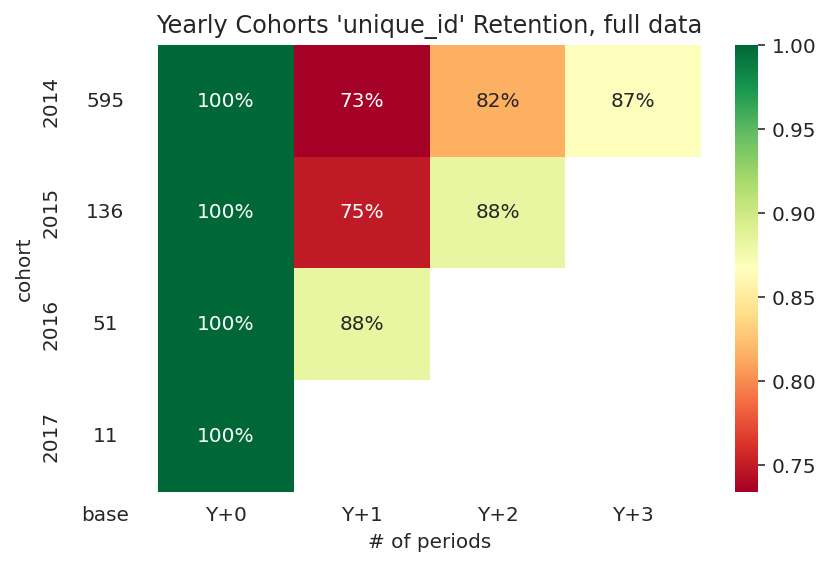

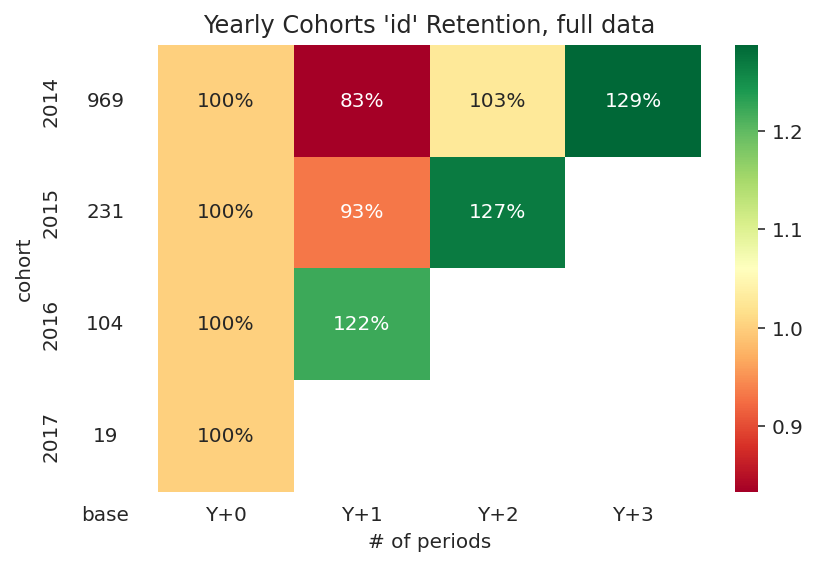

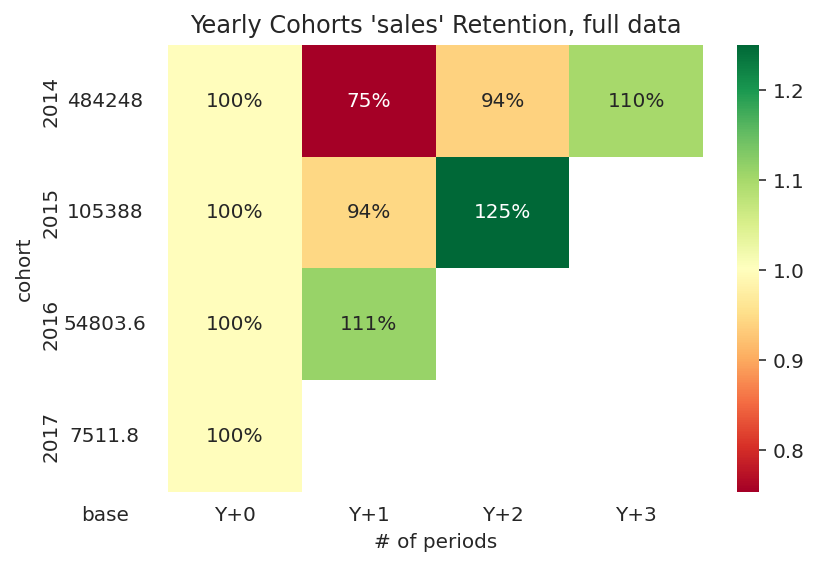

In [9]:
df_cohort = prep_table_for_cohort_analysis(df_full)
df_cohort['sales'] = df_cohort['sales'].round(1)

for col in ['unique_id', 'id', 'sales']:
    _ = show_table_and_plot_cohorts(df_cohort, col, extra_name='full data')

__Вывод по всему датасету:__

- Как мы можем увидеть, хоть и часть уникальных клиентов отпало (первый график, unique_id), число покупок (id) с оставшимися клиентами подросло, как и итоговые продажи (sales).

### Retention by segment

Processing segment: Consumer...
Processing segment: Corporate...
Processing segment: Home Office...


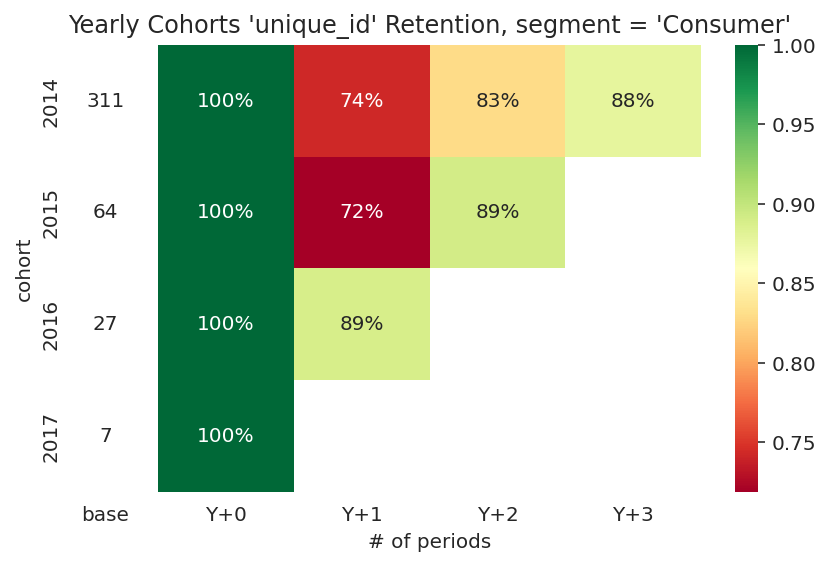

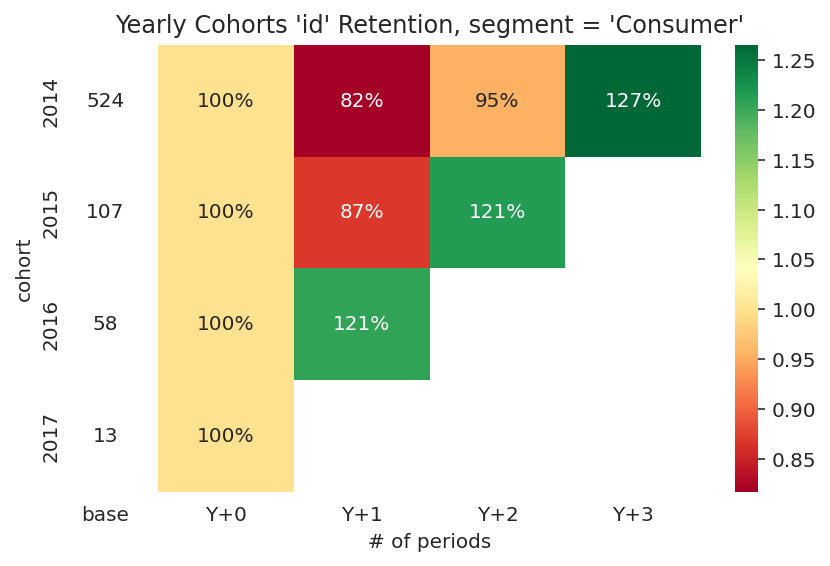

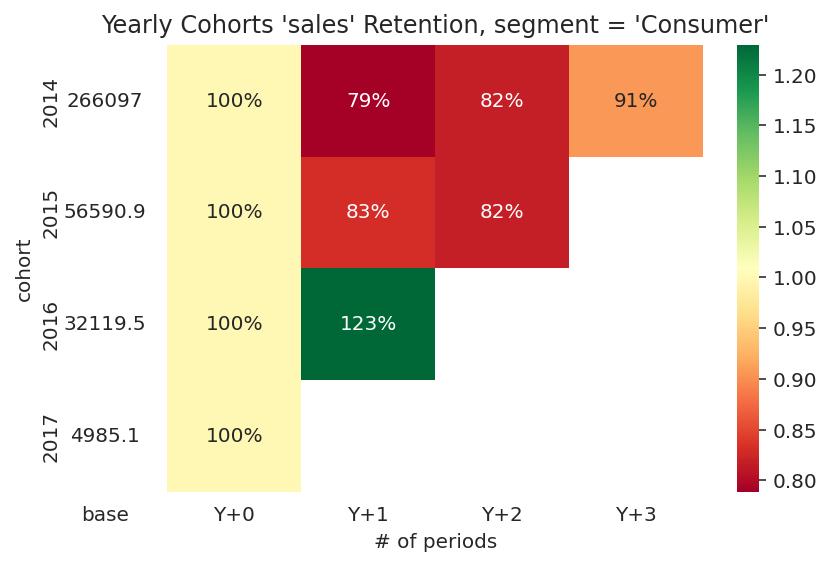

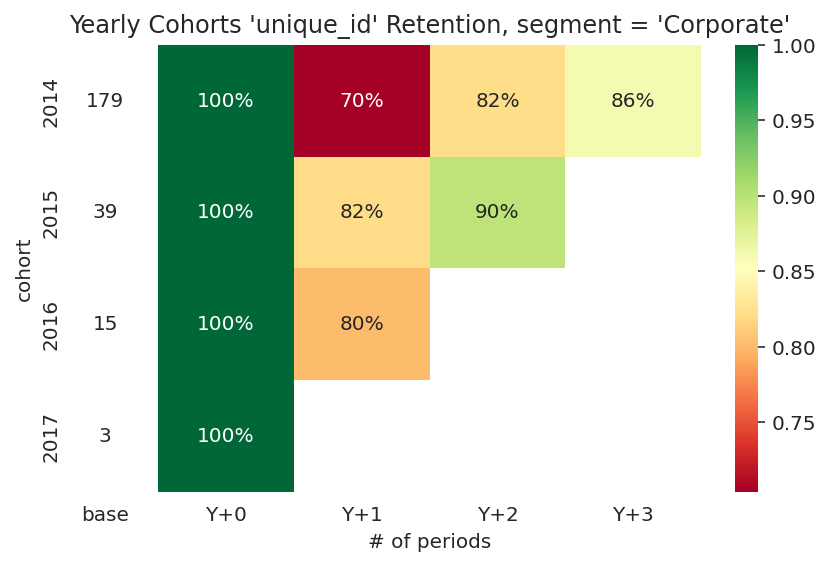

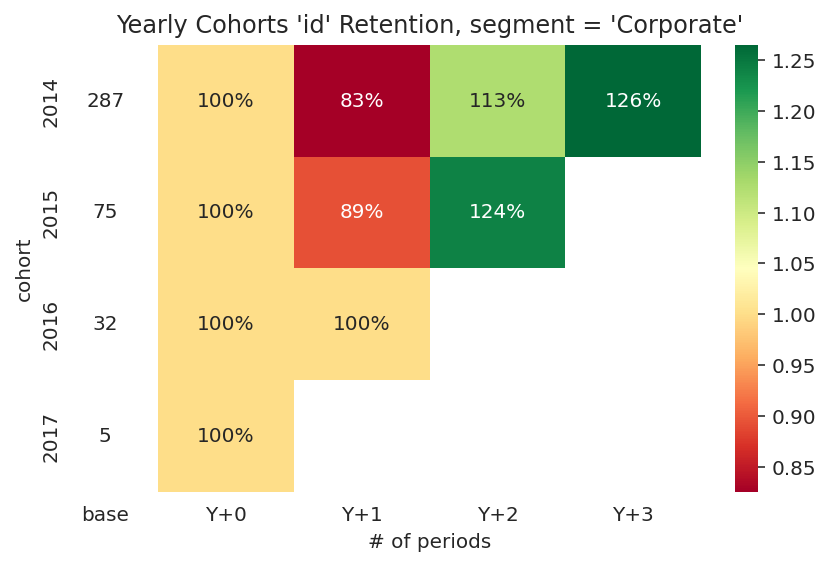

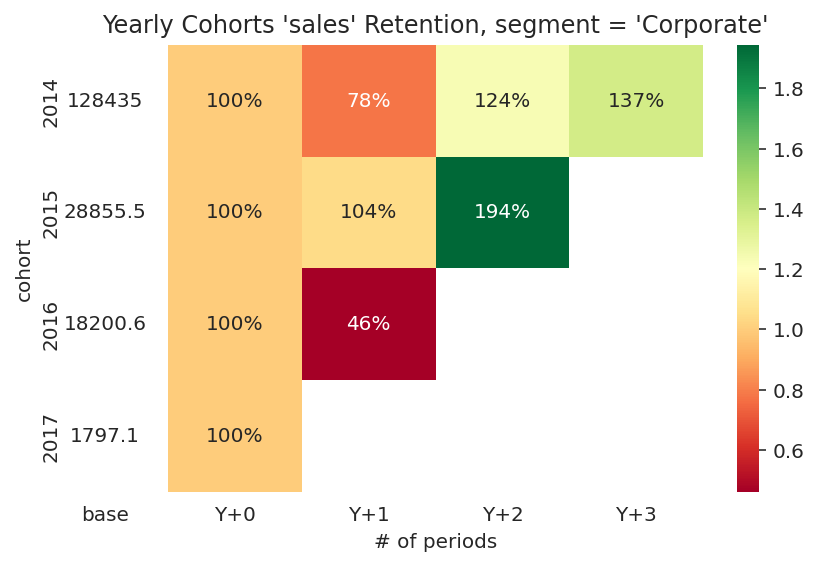

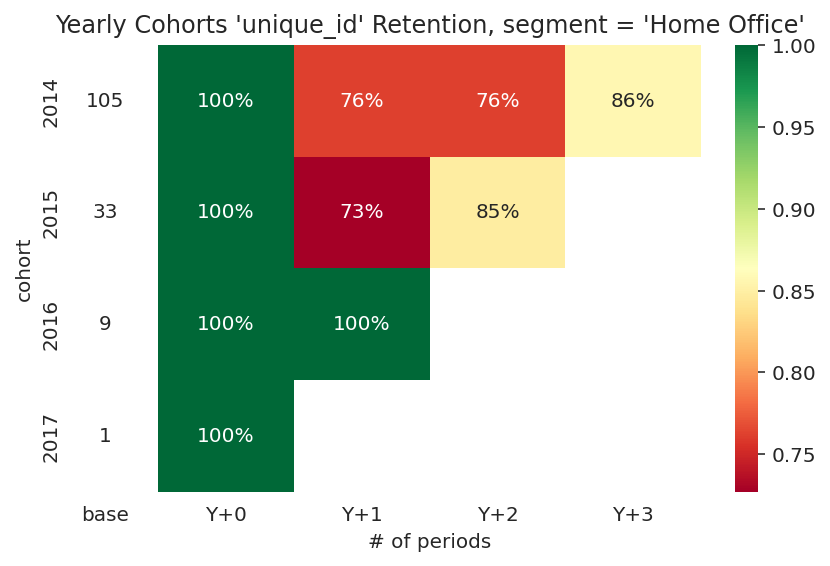

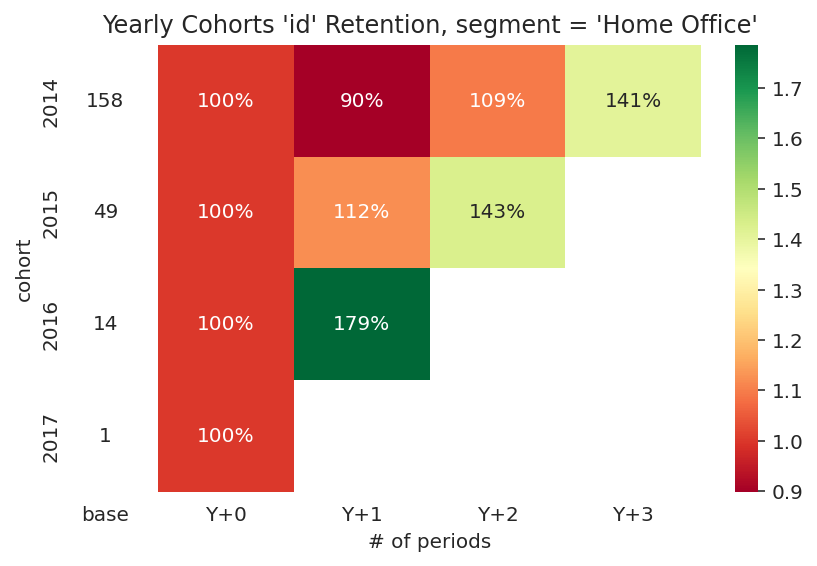

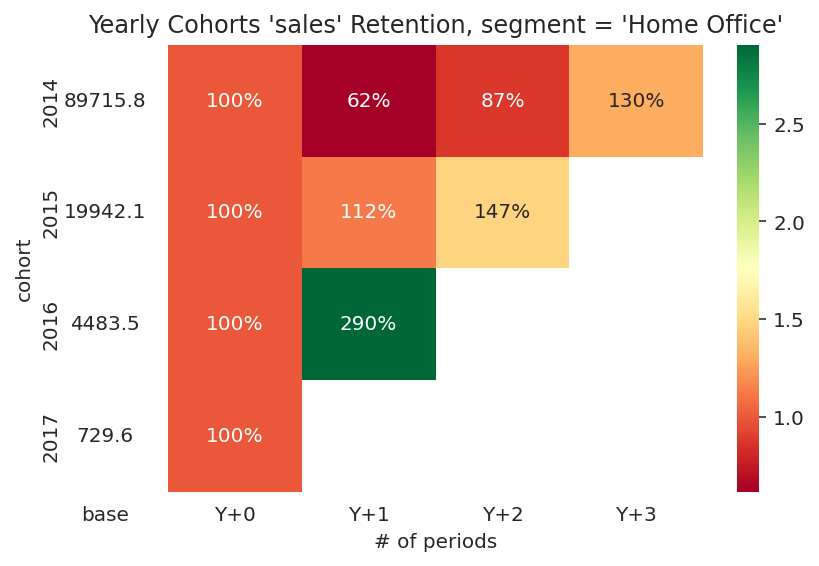

In [10]:
for segment in df_full.segment.unique():
    print(f'Processing segment: {segment}...')

    df_cohort = prep_table_for_cohort_analysis(df_full, f"segment == '{segment}'")
    df_cohort['sales'] = df_cohort['sales'].round(1)

    for col in ['unique_id', 'id', 'sales']:
        _ = show_table_and_plot_cohorts(df_cohort, col, extra_name=f"segment = '{segment}'")

__Выводы по сегментам:__

- Consumer: наблюдается небольшой отток клиентов, несмотря на рост числа покупок, продажи снизились
- Corporate: здесь всё неплохо, в когортах наблюдается небольшой отток клиентов, но продажи выросли значительно (за счёт когорт 2014 и 2015, когорта 2016 просела, но их группа и не очень многочисленна)
- Home Office: здесь наблюдается достаточно хорошая ситуация, несмотря на небольшой отток, кол-во продаж и и сумма соответствующих заказов сильно выросли

### Retention by ship_mode

Processing ship_mode: Standard...
Processing ship_mode: Same Day...
Processing ship_mode: First...
Processing ship_mode: Second...


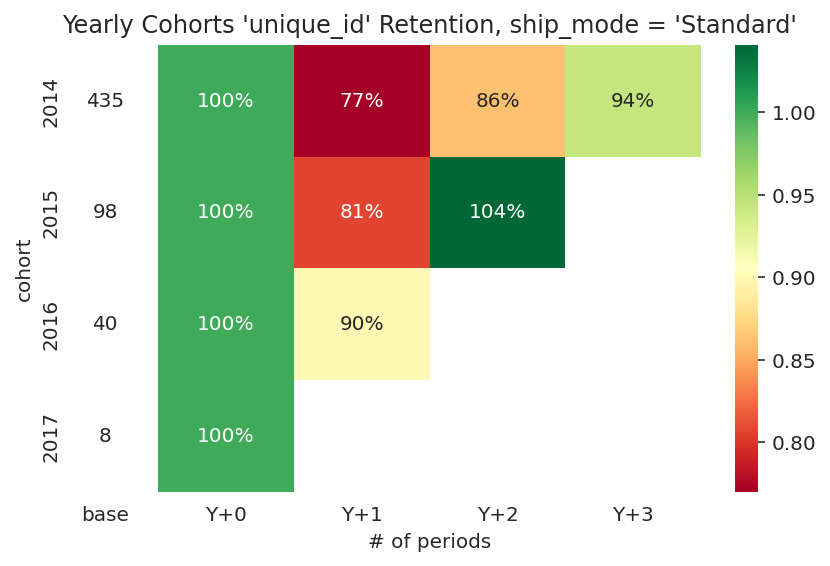

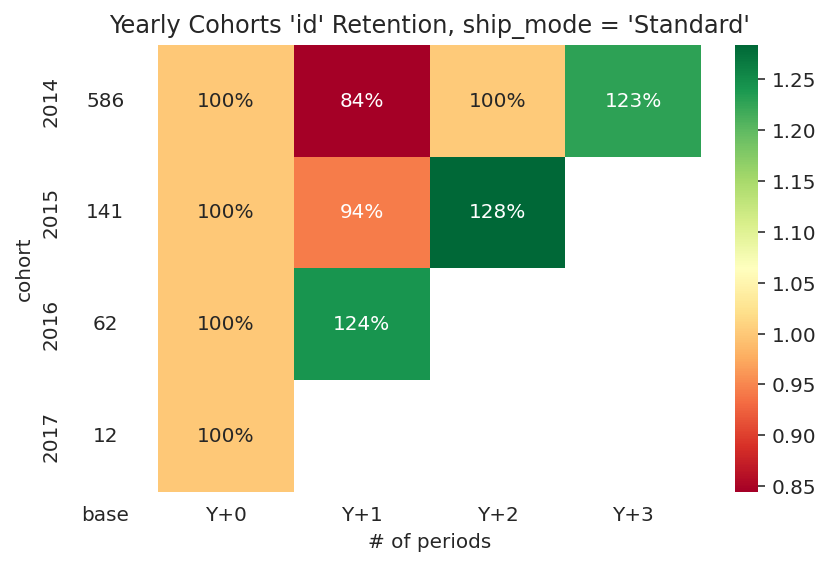

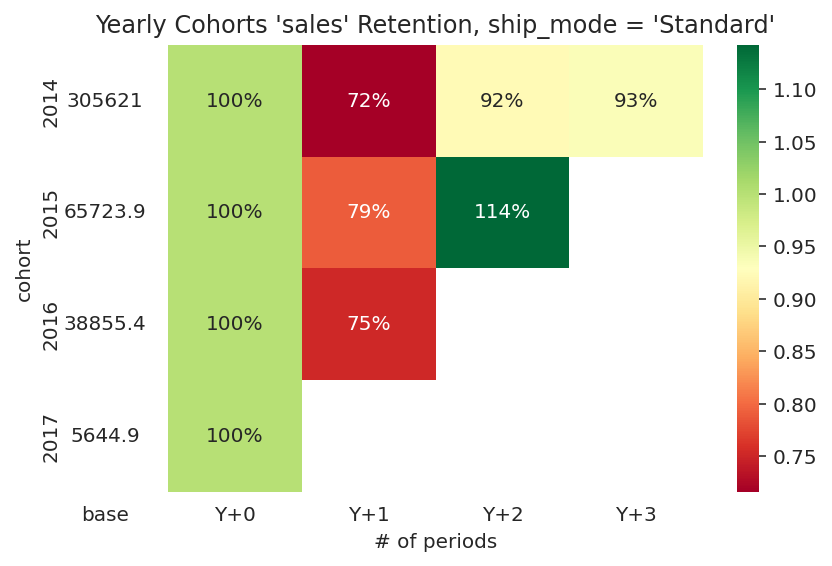

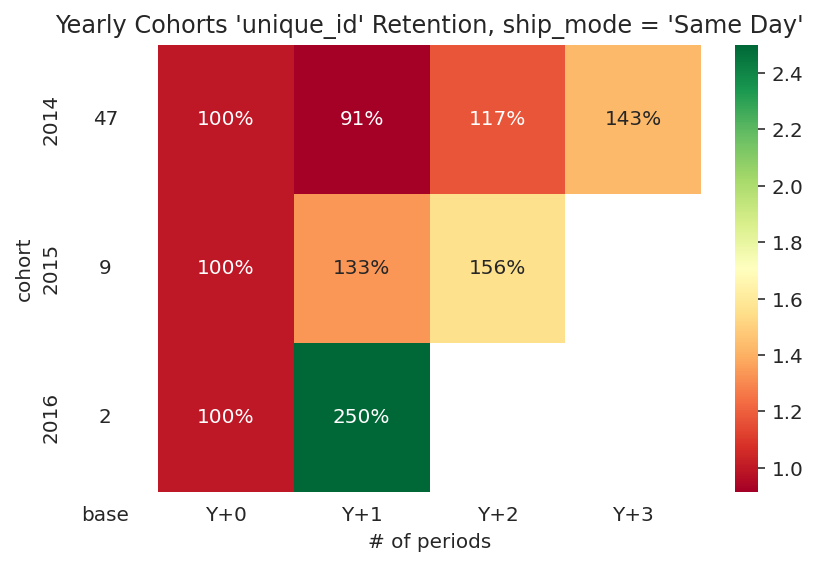

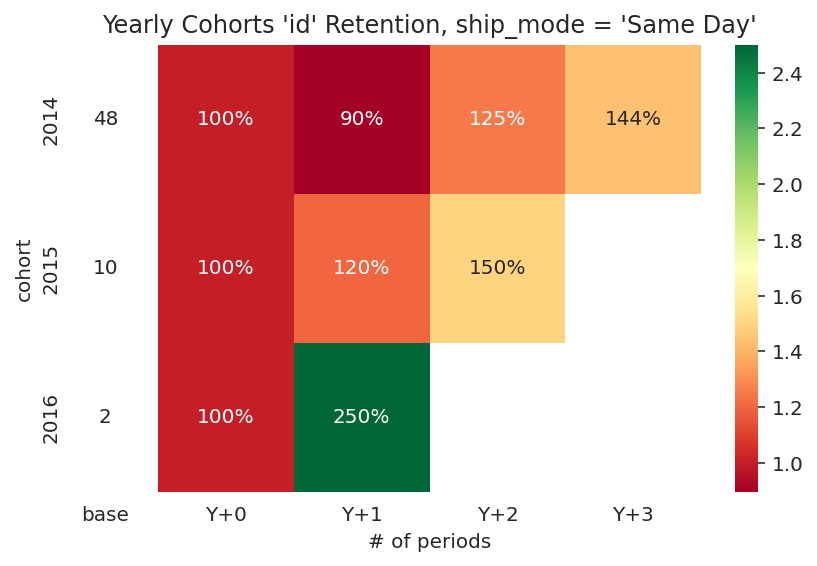

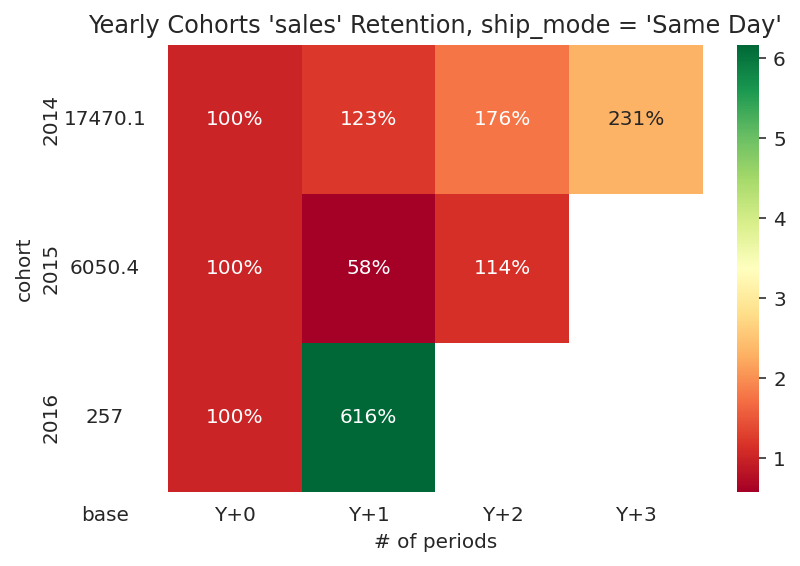

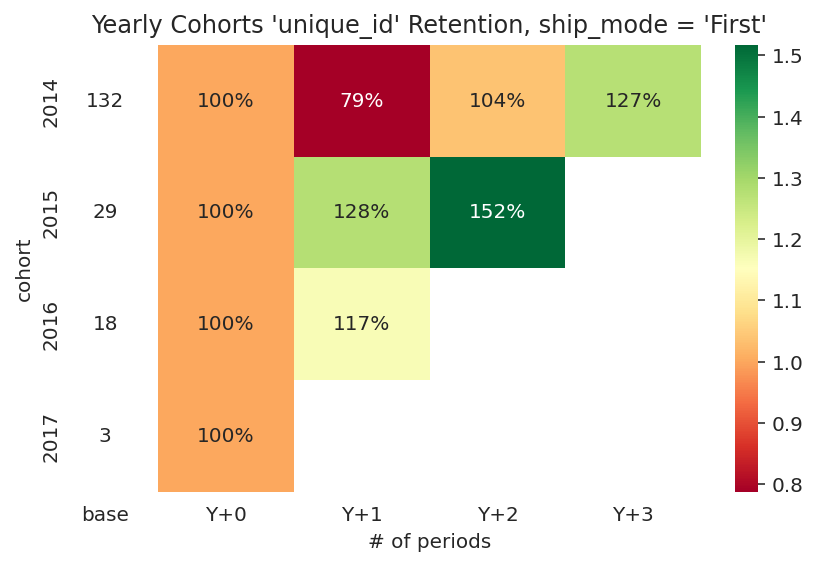

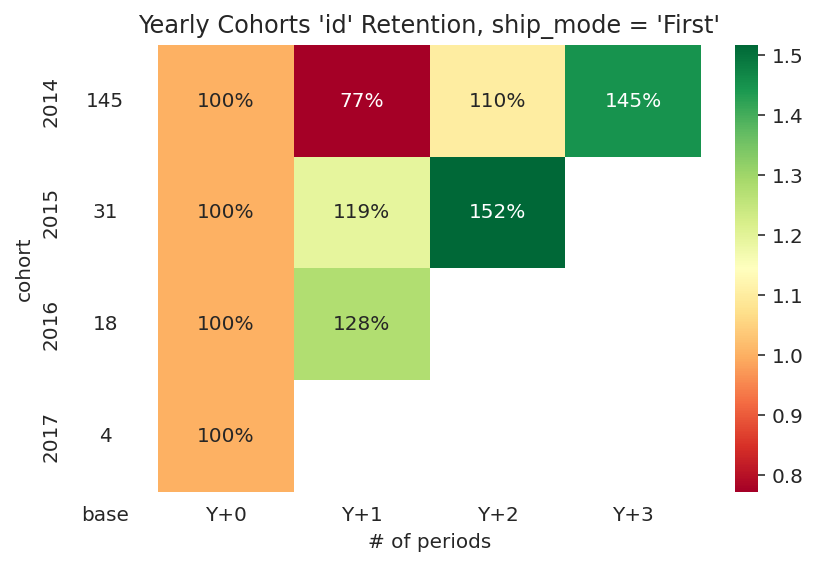

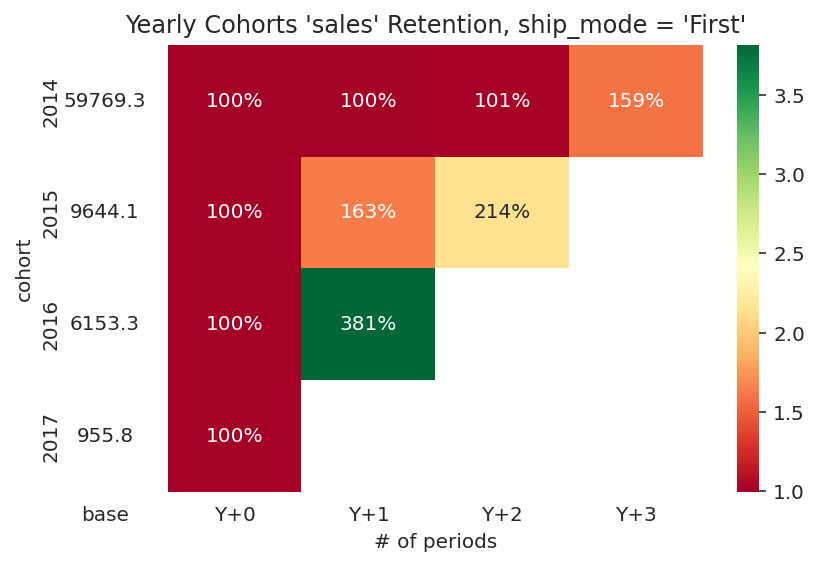

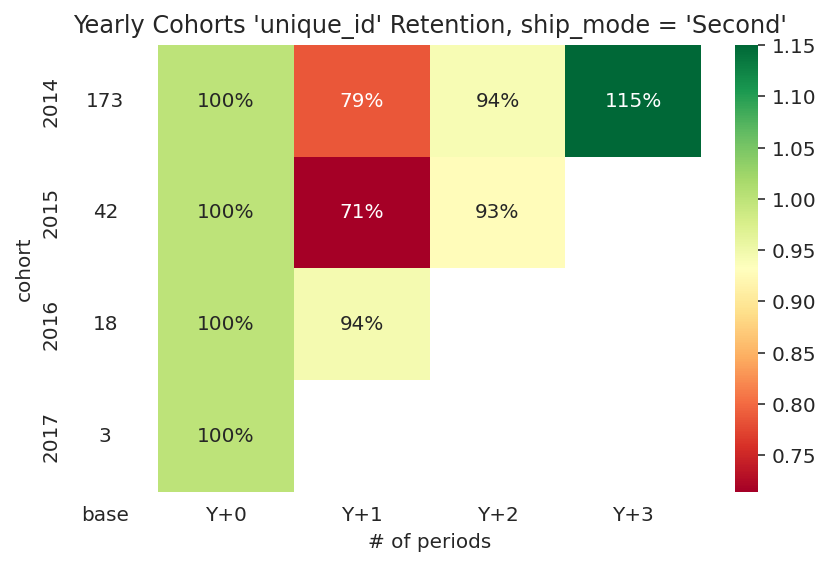

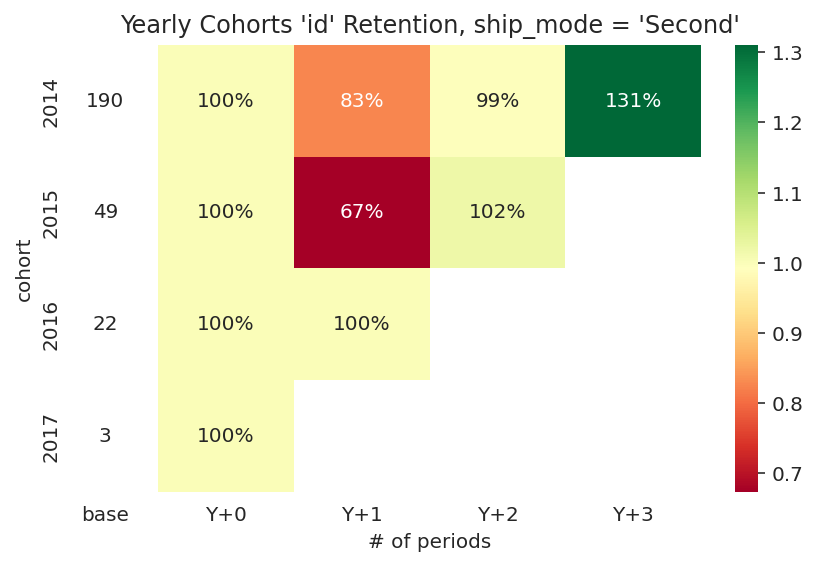

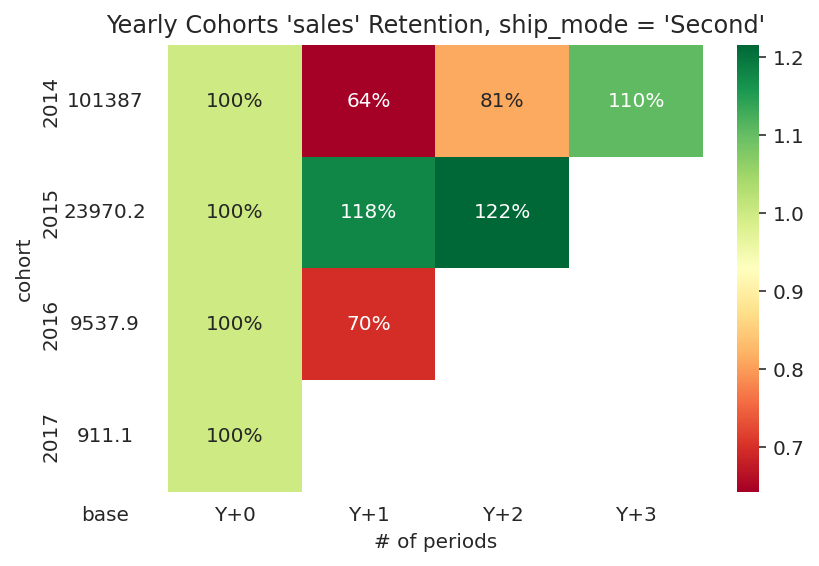

In [11]:
for ship_mode in df_full.ship_mode.unique():
    print(f'Processing ship_mode: {ship_mode}...')

    df_cohort = prep_table_for_cohort_analysis(df_full, f"ship_mode == '{ship_mode}'")
    df_cohort['sales'] = df_cohort['sales'].round(1)

    for col in ['unique_id', 'id', 'sales']:
        _ = show_table_and_plot_cohorts(df_cohort, col, extra_name=f"ship_mode = '{ship_mode}'")

__Выводы по методу доставки:__

- Standard: основная группа клиентов сохранилась, продажи относительно не изменились
- Same Day: очень хороший скачок по всем показателям во всех когортах
- First: аналогично Same Day
- Second: аналогично Standard

__Насчёт гипотезы:__

- В целом, кажется особых проблем с доставкой товаров не наблюдается, по крайней мере по рассмотренным выше показателям